In [1]:
# import packages
import string
import pandas as pd

# natural language toolkit
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# maths
from scipy.spatial.distance import euclidean
from math import sqrt

# load dataset
# M_metadata_v1.csv
movie_data = pd.read_csv('M_metadata_v1.csv', na_filter=False)

In [3]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Cast 1        799 non-null    object
 1   Cast 2        799 non-null    object
 2   Cast 3        799 non-null    object
 3   Cast 4        799 non-null    object
 4   Cast 5        799 non-null    object
 5   Cast 6        799 non-null    object
 6   Description   799 non-null    object
 7   Director 1    799 non-null    object
 8   Director 2    799 non-null    object
 9   Director 3    799 non-null    object
 10  Genre         799 non-null    object
 11  Rating        799 non-null    object
 12  Release Date  799 non-null    object
 13  Runtime       799 non-null    object
 14  Studio        799 non-null    object
 15  Title         799 non-null    object
 16  Writer 1      799 non-null    object
 17  Writer 2      799 non-null    object
 18  Writer 3      799 non-null    object
 19  Writer 4

In [121]:
# Initialize stopwords here and more
# initialise resources
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
stopwords = set(sw.words('english')).union(set(('c', 'r', 'u', 'film')))
stopwords = set(sw.words('english'))
rs = 21

In [126]:
def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens


In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

# function to visualise text cluster
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()

# creates tf-idf terms; a bit slow, run only occasionaly
# Param - document_col: collection of raw document text that you want to analyse
def calculate_tf_idf_terms(document_col):
    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(document_col)
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms

# visualisation of ZIPF law
# --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot.
    #           Num of terms to plot = N terms / itr_step
def visualise_zipf(terms, itr_step = 50):
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()

In [124]:
def preprocess_movie_data(raw_movie_data, optimise=True):
    # drop all cols except 'Description'
    preprocess_df = raw_movie_data.loc[:, ['Description']]
    
    # if default analysis
    if optimise==True:
        stopwords = set(sw.words('english'))
        tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    else: # add additional stop words and strip noisy phrases from data
        stopwords = set(sw.words('english')).union(set(('c', 'r', 'u', 'film')))
        preprocess_df['Description'] = preprocess_df['Description'].str.split('\. --',expand=True).iloc[:,0]
        tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=0.05, max_df=0.7)
    
    X = tfidf_vec.fit_transform(preprocess_df.Description)
    
    return tfidf_vec, X

In [125]:
# Task 3.4
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(movie_data.Description)

# number of input features
print(len(tfidf_vec.get_feature_names_out()))

/Users/miriamsarpong/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


65478


In [112]:
# Task 3.6 ?
# K means clustering using the term vector
kmeans = KMeans(n_clusters=10, random_state=rs).fit(X)

# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names_out())

/Users/miriamsarpong/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Top terms for cluster 0: peter, bob, fred, set, war, 
Top terms for cluster 1: world, save, must, destroy, evil, 
Top terms for cluster 2: film, documentary, song, feature, rock, 
Top terms for cluster 3: c, official, c official, site, official site, 
Top terms for cluster 4: life, find, love, one, time, 
Top terms for cluster 5: alien, colony, ripley, planet, group, 
Top terms for cluster 6: award, academy award, academy, documentary, film, 
Top terms for cluster 7: jack, disney, young, find, white, 
Top terms for cluster 8: prince, king, queen, year, narnia, 
Top terms for cluster 9: family, new, one, film, kid, 


In [113]:
# Task 3.2
terms = calculate_tf_idf_terms(movie_data.Description)

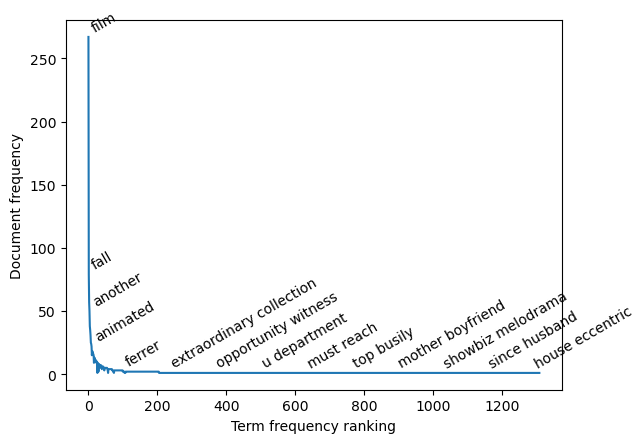

In [114]:
visualise_zipf(terms)

In [115]:
# Task 3.4 - trying another tf idf vectoriser, to compare
# tf idf vectoriser
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2),
                            min_df=2, max_df=0.8)
X_filter = filter_vec.fit_transform(movie_data.Description)

# number of input features
print(len(filter_vec.get_feature_names_out()))

9924


In [116]:
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=10, random_state=rs).fit(X_filter)

# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, 
                       filter_vec.get_feature_names_out())

Top terms for cluster 0: war, c, c official, official, site, 
Top terms for cluster 1: boy, girl, year, world, film, 
Top terms for cluster 2: jack, town, woman, friend, find, 
Top terms for cluster 3: rachel, murder, peter, star, love, 
Top terms for cluster 4: batman, pokemon, celebi, keaton, release, 
Top terms for cluster 5: family, film, friend, take, school, 
Top terms for cluster 6: disney, new, prince, adventure, city, 
Top terms for cluster 7: christmas, santa, holiday, claus, toy, 
Top terms for cluster 8: film, documentary, interview, voice, footage, 
Top terms for cluster 9: life, time, one, love, world, 


In [ ]:
# visual

In [117]:
# Trying with SVD
svd = TruncatedSVD(n_components=100, random_state=42)
X_trans = svd.fit_transform(X_filter)

In [118]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names_out()

# visualise word - concept/component relationships
for comp_num in range(10):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :5]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 film, life, one, love, year, 
Top terms in component #1 film, documentary, c, c official, official, 
Top terms in component #2 earth, alien, adventure, planet, save, 
Top terms in component #3 life, site, c official, alien, official site, 
Top terms in component #4 christmas, holiday, santa, family, claus, 
Top terms in component #5 boy, school, story, year, family, 
Top terms in component #6 year, school, harry, year old, old, 
Top terms in component #7 love, story, war, christmas, fall, 
Top terms in component #8 city, harry, christmas, potter, harry potter, 
Top terms in component #9 harry, best, academy, academy award, award, 


In [119]:
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=10, random_state=rs).fit(X_trans)

# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names_out())

/Users/miriamsarpong/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Top terms for cluster 0: film, documentary, year, life, interview, 
Top terms for cluster 1: alien, earth, planet, space, film, 
Top terms for cluster 2: award, academy, academy award, r, best, 
Top terms for cluster 3: c official, official site, site, official, c, 
Top terms for cluster 4: family, christmas, boy, child, year, 
Top terms for cluster 5: harry, potter, harry potter, wizard, black, 
Top terms for cluster 6: school, high, get, city, discover, 
Top terms for cluster 7: story, voice, war, world, set, 
Top terms for cluster 8: life, love, woman, find, one, 
Top terms for cluster 9: ernest, kid, treehouse neighborhood, fill goofy, entry ernest, 


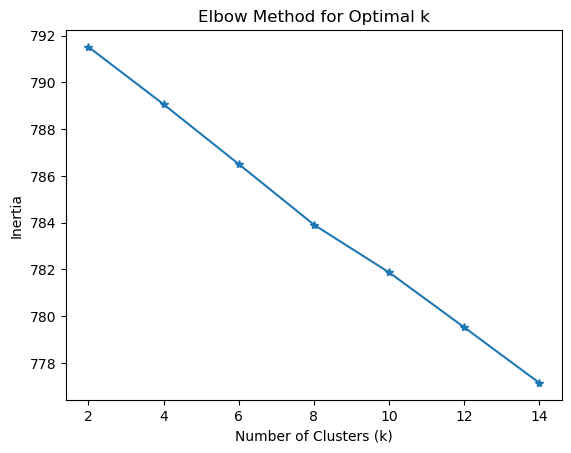

In [128]:
# Task 3.5
#list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 2):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)
    
# plot the inertia vs K values
plt.plot(range(2,15,2), inertia_vals, marker='*')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

## 3.1
### Variables included in analysis

What were the variables roles and measurement levels set to? Justify choices.

We drop all columns except Description, which we primarily focused on.  It contains textual descriptions of the movies, and its measurement level is "Text" or "Nominal" because it consists of unstructured text data. The role of the "Description" column is to provide textual content for clustering movies based on similar topics. 

1. Drop all columns except Description




## 3.2
### 10 least useful terms for Clustering

Based on the ZIPF plot, list the top 10 terms that will be least useful for clustering purpose.

 - film


## 3.3
### Any frequent terms disregarded?
Justify choices.

We included stop words and   to filter out common and frequent terms that are less informative and can be disregarded to improve the qaulity of clustering results. 

drop_terms = set(('c', 'r', 'u', 'film'))



## 3.4
### Justify the term weighting option selected.
### What is the number of input features available to execute k-means clustering?

Please note that how the original text data is converted into a feature set to support text analysis.

TF-IDF (Term Frequency-Inverse Document Frequency) was selected as the term weigting option. It is suitable for text analysis as it assigns higher weights to terms that are important within a specific document, but not too common across all documents. The number of input features for k-means clustering is 65478, which corresponds to the number of unique terms in the "Description" column. 

## 3.5
### Find and plot optimal `k`
### Interpret results.

# plot
interpreatiton

- elbow method to find the optimal value of k



## 3.6
### How many clusters are generated?
* Provide a way to meaningfully name each cluster.
* Display the results.



## 3.7
### How the outcome of this analysis can be used by decision makers?

Give an application or an example where the analysis results can be used by the cinema.

- Movie recommendations: 

- Content Curation:

